In [1]:
from sklearn.datasets import load_svmlight_file, make_classification
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
import time

## Helpers

In [2]:
def logreg_grad(w, X, y):
    '''
    Numpy computation for gradient of logistic regression

    Params:
    -------
    w : array
        weights of ridge
    X : array
        Dataset
    y : array
        labels
    l : float
        lambda parameter for ridge
    mode : string
           In which mode to compute logreg: None, 'lasso' or 'ridge'
    '''
    y_pred = 1 / (1 + np.exp(-X @ w))
    g = np.dot(X.T, (y_pred - y)) / len(y)
    return g

In [3]:
def init_M(X, y, LMO, R):
    eps = 1e-3
    w = np.zeros(X.shape[-1])
    grad = logreg_grad(w, X, y)
    s = LMO(grad, w, R)
    d_0 = s - w
    grad_update = logreg_grad(w + eps * d_0, X, y)
    M = np.linalg.norm(grad - grad_update) / (eps * np.linalg.norm(d_0))
    return M

In [4]:
def make_experiment(exp_params):
    xt = exp_params['x0']
    X = exp_params['X']
    y = exp_params['y']
    objectives = []
    times = []
    start = time.time()

    for i in trange(exp_params['n_iter']):
        grad = logreg_grad(xt, X, y)
        st = exp_params['LMO'](-grad, xt, exp_params['R'])
        dt = st - xt
        gt = np.dot(-grad, dt)
        gamma = exp_params['gamma_step'](gt, dt, L, i, exp_params, xt)
        xt = xt + gamma * dt

        objectives.append(exp_params['objective'](xt, X, y))
        times.append(time.time() - start)

    return objectives, times

In [5]:
def L_constant(X, l=0):
    '''
    Estimation of the Lipschitz constant

    Params:
    -------
    X : array
        Dataset
    l : float
        lambda parameter for ridge
    '''
    X_norm = np.sum([np.linalg.norm(x) ** 2 for x in X]) / (4 * X.shape[0])
    return X_norm + l

In [6]:
def loss_logreg(w, X, y):
    y_pred = 1/ (1 + np.exp(-X @ w))
    loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
    return loss

## Datasets preparation


### Mushrooms

In [7]:
dataset = "./data/mushrooms.txt"


data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

y = y - 1
mushrooms_train, mushrooms_test, mushrooms_y_train, mushrooms_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

L = L_constant(mushrooms_train)
L

5.25

### Synthetic normal

In [8]:
X, y = make_classification(
    n_samples=5000,
    n_features=50,
    n_informative=2,
    class_sep=1,
    random_state=17,
)

normal_train, normal_test, normal_y_train, normal_y_test = train_test_split(X, y, test_size=0.2, random_state=17)

L = L_constant(normal_train)
L

12.60594349952399

### Synthetic high dimensional

In [9]:
X, y = make_classification(
    n_samples=5000,
    n_features=1024,
    n_informative=3,
    class_sep=1,
    random_state=17,
)

dim_train, dim_test, dim_y_train, dim_y_test = train_test_split(X, y, test_size=0.2, random_state=17)

L = L_constant(dim_train)
L

257.7497456427287

### Synthetic ill conditioned

In [10]:
X, y = make_classification(
    n_samples=5000,
    n_features=50,
    n_informative=5,
    class_sep=20,
    random_state=17,
)

ill_train, ill_test, ill_y_train, ill_y_test = train_test_split(X, y, test_size=0.2, random_state=17)

L = L_constant(ill_train)
L

873.7288357477153

## Gamma steps

In [11]:
def trivial(gt, dt, L, i, exp_params, xt):
    return 2 / (i + 10)

def demyanov_rubinov(gt, dt, L, i, exp_params, xt):
    return min(1, gt / (L * np.linalg.norm(dt) ** 2))

def Q(f, gamma, g_t, M, d):
    return f - gamma * g_t + gamma ** 2 * M * np.linalg.norm(d) ** 2 / 2

def backtracking_line_search(gt, dt, L, i, exp_params, xt):
    Mt = exp_params['Mt']
    Mt = Mt * 0.9
    X = exp_params['X']
    y = exp_params['y']
    gamma = min(1, gt / (Mt * np.linalg.norm(dt) ** 2))
    while exp_params['objective'](xt + gamma * dt, X, y) > Q(exp_params['objective'](xt, X, y), gamma, gt, Mt, dt):
        Mt = 2 * Mt
    exp_params['Mt'] = Mt
    return gamma

def armijo(gt, dt, L, i, exp_params, xt):
    
    X = exp_params['X']
    y = exp_params['y']
    alpha = exp_params['alpha_init']
    
    while (exp_params['objective'](xt + alpha * dt, X, y) - exp_params['objective'](xt, X, y)) > -1e-4 * alpha * gt:
        alpha /= 2
    
    exp_params['alpha_init'] = alpha
    return alpha

## LMOS

In [12]:
def LMO_L1(g, z, R=1.0):
    '''
    Linear Maximization Oracle for l1
    '''
    i = np.argmax(np.abs(g))
    s = np.zeros_like(z)
    s[i] = R * np.sign(g[i])
    return s

def LMO_L2(g, z, R=1.0):
    '''
    Linear Maximization Oracle for l2
    '''
    return R * g / np.linalg.norm(g)

## Experiments
### Rosen

In [82]:
from scipy.optimize import rosen, rosen_der


def make_experiment_rosen(exp_params):
    xt = exp_params['x0']
    objectives = []
    trajectory = [xt]
    times = []
    start = time.time()

    for i in trange(exp_params['n_iter']):
        grad = rosen_der(xt)
        st = exp_params['LMO'](-grad, xt, exp_params['R'])
        dt = st - xt
        gt = np.dot(-grad, dt)
        gamma = exp_params['gamma_step'](gt, dt, L, i, exp_params, xt)
        xt = xt + gamma * dt
        trajectory.append(xt)
        objectives.append(exp_params['objective'](xt))
        times.append(time.time() - start)

    return objectives, times, trajectory

def init_M_rosen(dim, LMO, R):
    eps = 1e-3
    w = np.zeros(dim)
    # grad = logreg_grad(w, X, y)
    grad = rosen_der(w)
    s = LMO(grad, w, R)
    d_0 = s - w
    # grad_update = logreg_grad(w + eps * d_0, X, y)
    grad_update = rosen_der(w + eps * d_0)
    M = np.linalg.norm(grad - grad_update) / (eps * np.linalg.norm(d_0))
    return M

def backtracking_line_search_rosen(gt, dt, L, i, exp_params, xt):
    Mt = exp_params['Mt']
    Mt = Mt * 0.9
    gamma = min(1, gt / (Mt * np.linalg.norm(dt) ** 2))
    while exp_params['objective'](xt + gamma * dt) > Q(exp_params['objective'](xt), gamma, gt, Mt, dt):
        Mt = 2 * Mt
    exp_params['Mt'] = Mt
    return gamma

def armijo_rosen(gt, dt, L, i, exp_params, xt):
    alpha = exp_params['alpha_init']
    
    while (exp_params['objective'](xt + alpha * dt) - exp_params['objective'](xt)) > -1e-4 * alpha * gt:
        alpha /= 2
    
    exp_params['alpha_init'] = alpha
    return alpha

#### l1

In [88]:
n_iter = 1000
dim = 2

trivial_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': trivial,
    'objective': rosen,
    'n_iter': n_iter,
}
losses_trivial, times_trivial, trajectory_trivial = make_experiment_rosen(trivial_exp_rosen)

dr_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': rosen,
    'n_iter': n_iter,
}
losses_dr, times_dr, trajectory_dr = make_experiment_rosen(dr_exp_rosen)

ls_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': backtracking_line_search_rosen,
    'objective': rosen,
    'n_iter': n_iter,
    'Mt': init_M_rosen(dim, LMO_L1, 100)
}
losses_ls, times_ls, trajectory_ls = make_experiment_rosen(ls_exp_rosen)

armijo_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': armijo_rosen,
    'alpha_init': 1.0 / 16,
    'objective': rosen,
    'n_iter': n_iter,
}
losses_armijo, times_armijo, trajectory_armijo = make_experiment_rosen(armijo_exp_rosen)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 28808.42it/s]


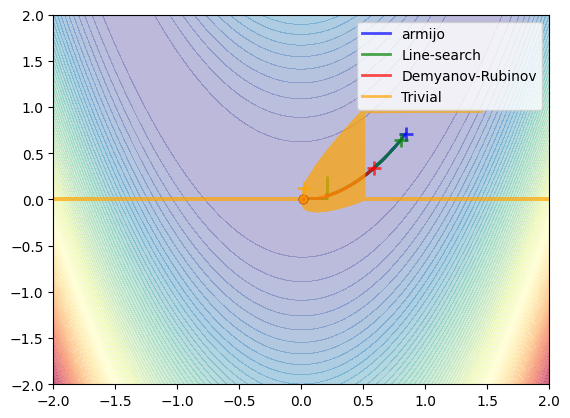

In [90]:
def plot_trajectory(trajectory, c, label, alpha):
    plt.plot(trajectory[:,0],trajectory[:,1],lw=2,c=c, label=label, alpha=alpha)
    plt.scatter(trajectory[0,0],trajectory[0,1],s=100,c=c,marker='.',zorder=10,lw=2, alpha=alpha)
    plt.scatter(trajectory[-1,0],trajectory[-1,1],s=100,c=c,marker='+',zorder=10,lw=2, alpha=alpha)


x, y = np.meshgrid(np.linspace(-2, 2, 1000),
                   np.linspace(-2, 2, 1000))


plt.contourf(x, y, rosen([x, y]), levels=100, cmap='Spectral_r', alpha=0.4)

plot_trajectory(np.array(trajectory_armijo), c='blue', label='armijo', alpha=0.7)
plot_trajectory(np.array(trajectory_ls), c='green', label='Line-search', alpha=0.7)
plot_trajectory(np.array(trajectory_dr), c='red', label='Demyanov-Rubinov', alpha=0.7)
plot_trajectory(np.array(trajectory_trivial), c='orange', label='Trivial', alpha=0.7)

plt.xlim(-2,2)
plt.ylim(-2,2)

plt.legend()
plt.show()

#### l2

In [91]:
n_iter = 1000
dim = 2

trivial_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': trivial,
    'objective': rosen,
    'n_iter': n_iter,
}
losses_trivial, times_trivial, trajectory_trivial = make_experiment_rosen(trivial_exp_rosen)

dr_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': rosen,
    'n_iter': n_iter,
}
losses_dr, times_dr, trajectory_dr = make_experiment_rosen(dr_exp_rosen)

ls_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': backtracking_line_search_rosen,
    'objective': rosen,
    'n_iter': n_iter,
    'Mt': init_M_rosen(dim, LMO_L2, 100)
}
losses_ls, times_ls, trajectory_ls = make_experiment_rosen(ls_exp_rosen)

armijo_exp_rosen = {
    'x0': np.zeros(dim) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': armijo_rosen,
    'alpha_init': 1.0 / 16,
    'objective': rosen,
    'n_iter': n_iter,
}
losses_armijo, times_armijo, trajectory_armijo = make_experiment_rosen(armijo_exp_rosen)

100%|██████████| 1000/1000 [00:00<00:00, 29701.76it/s]


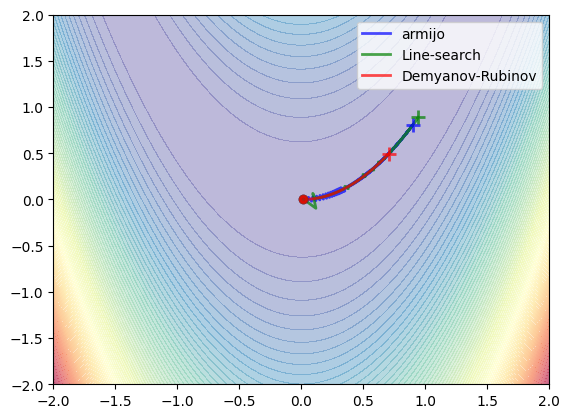

In [96]:
def plot_trajectory(trajectory, c, label, alpha):
    plt.plot(trajectory[:,0],trajectory[:,1],lw=2,c=c, label=label, alpha=alpha)
    plt.scatter(trajectory[0,0],trajectory[0,1],s=100,c=c,marker='.',zorder=10,lw=2, alpha=alpha)
    plt.scatter(trajectory[-1,0],trajectory[-1,1],s=100,c=c,marker='+',zorder=10,lw=2, alpha=alpha)


x, y = np.meshgrid(np.linspace(-2, 2, 1000),
                   np.linspace(-2, 2, 1000))


plt.contourf(x, y, rosen([x, y]), levels=100, cmap='Spectral_r', alpha=0.4)

plot_trajectory(np.array(trajectory_armijo), c='blue', label='armijo', alpha=0.7)
plot_trajectory(np.array(trajectory_ls), c='green', label='Line-search', alpha=0.7)
plot_trajectory(np.array(trajectory_dr), c='red', label='Demyanov-Rubinov', alpha=0.7)
# plot_trajectory(np.array(trajectory_trivial), c='orange', label='Trivial', alpha=0.7)


plt.xlim(-2,2)
plt.ylim(-2,2)

plt.legend()
plt.show()

### COPT

In [13]:
from copt.loss import LogLoss


def make_experiment_copt(exp_params):
    xt = exp_params['x0']
    X = exp_params['X']
    y = exp_params['y']
    f = exp_params['f']
    objectives = []
    times = []
    start = time.time()

    for i in trange(exp_params['n_iter']):
        # grad = logreg_grad(xt, X, y)
        loss, grad = f.f_grad(xt)
        st = exp_params['LMO'](-grad, xt, exp_params['R'])
        dt = st - xt
        gt = np.dot(-grad, dt)
        gamma = exp_params['gamma_step'](gt, dt, L, i, exp_params, xt)
        xt = xt + gamma * dt

        # objectives.append(exp_params['objective'](xt, X, y))
        objectives.append(loss)
        times.append(time.time() - start)

    return objectives, times

In [14]:
# For better performance with copt

def init_M_copt(X, y, LMO, R, grad_func):
    eps = 1e-3
    w = np.zeros(X.shape[-1])
    # grad = logreg_grad(w, X, y)
    grad = grad_func(w)[-1]
    s = LMO(grad, w, R)
    d_0 = s - w
    # grad_update = logreg_grad(w + eps * d_0, X, y)
    grad_update = grad_func(w + eps * d_0)[-1]
    M = np.linalg.norm(grad - grad_update) / (eps * np.linalg.norm(d_0))
    return M

### Gisette
https://archive.ics.uci.edu/dataset/170/gisette

In [ ]:
from copt.datasets import load_gisette, load_covtype


X_gisette, y_gisette = load_gisette() # load_madelon, load_covtype

f = LogLoss(X_gisette, y_gisette)
X_gisette.shape

(7000, 5000)

#### l1

In [16]:
n_iter = 1000

trivial_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_trivial, times_trivial = make_experiment_copt(trivial_exp_gisette)

dr_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_dr, times_dr = make_experiment_copt(dr_exp_gisette)

ls_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': n_iter,
    'Mt': init_M_copt(X_gisette, y_gisette, LMO_L1, 100, f.f_grad)
}
losses_ls, times_ls = make_experiment_copt(ls_exp_gisette)

armijo_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': armijo,
    'alpha_init': 1.0 / 16,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_armijo, times_armijo = make_experiment_copt(armijo_exp_gisette)

100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]


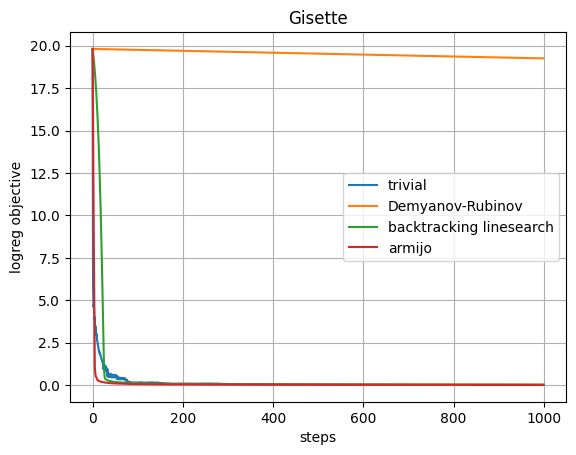

In [17]:
plt.title('Gisette')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label=f'armijo')

plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.4)
plt.show();

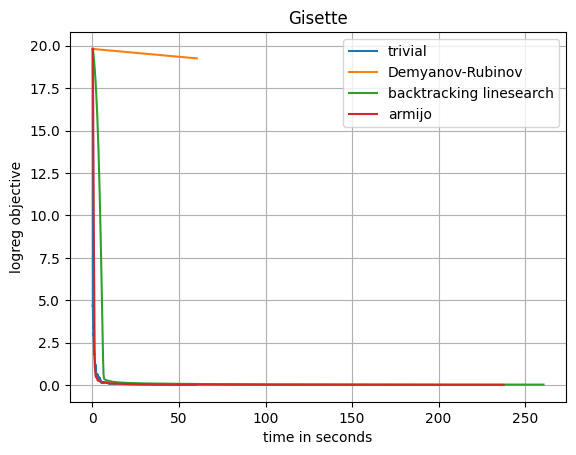

In [18]:
plt.title('Gisette')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armijo, losses_armijo, label='armijo')

plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.35)
# plt.xlim(0, 30)
plt.show();

#### l2

In [31]:
n_iter = 1000

trivial_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_trivial, times_trivial = make_experiment_copt(trivial_exp_gisette)

dr_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_dr, times_dr = make_experiment_copt(dr_exp_gisette)

ls_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': n_iter,
    'Mt': init_M_copt(X_gisette, y_gisette, LMO_L2, 100, f.f_grad)
}
losses_ls, times_ls = make_experiment_copt(ls_exp_gisette)

armijo_exp_gisette = {
    'X': X_gisette,
    'y': y_gisette,
    'f': f,
    'x0': np.zeros(X_gisette.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': armijo,
    'alpha_init': 1.0 / 16,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_armijo, times_armijo = make_experiment_copt(armijo_exp_gisette)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/b0/txks7w3n6d5bnxbphmt_jq0w0000gn/T/ipykernel_18185/3423734814.py:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
/var/folders/b0/txks7w3n6d5bnxbphmt_jq0w0000gn/T/ipykernel_18185/3423734814.py:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


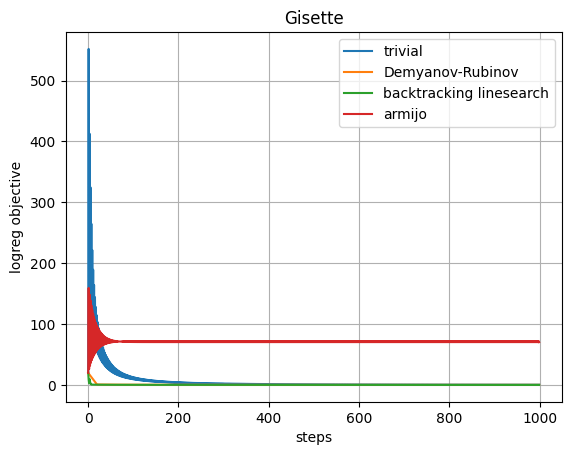

In [32]:
plt.title('Gisette')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label=f'armijo')

plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.4)
plt.show();

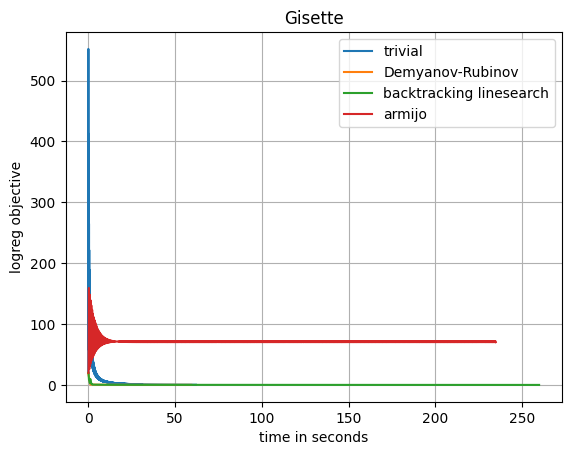

In [33]:
plt.title('Gisette')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armijo, losses_armijo, label='armijo')

plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.35)
# plt.xlim(0, 30)
plt.show();

## Covertype

https://archive.ics.uci.edu/dataset/31/covertype

In [34]:
from copt.datasets import load_covtype


X_covtype, y_covtype = load_covtype()

f = LogLoss(X_covtype, y_covtype)
X_covtype.shape

(581012, 54)

### l1

In [24]:
n_iter = 1000

trivial_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_trivial, times_trivial = make_experiment_copt(trivial_exp_covtype)

dr_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_dr, times_dr = make_experiment_copt(dr_exp_covtype)

ls_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': n_iter,
    'Mt': init_M_copt(X_covtype, y_covtype, LMO_L1, 100, f.f_grad)
}
losses_ls, times_ls = make_experiment_copt(ls_exp_covtype)

armijo_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': armijo,
    'alpha_init': 1.0 / 16,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_armijo, times_armijo = make_experiment_copt(armijo_exp_covtype)

100%|██████████| 1000/1000 [01:11<00:00, 13.90it/s]


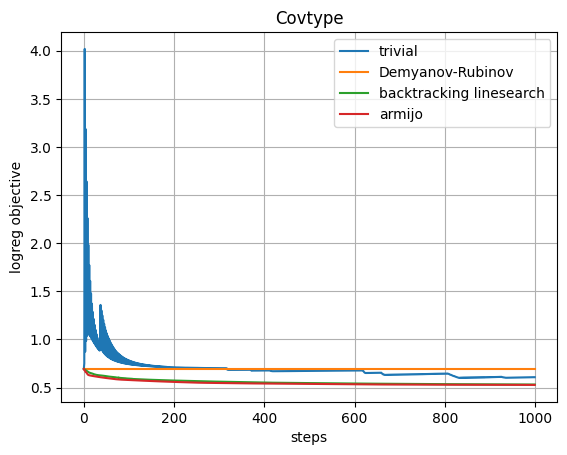

In [25]:
plt.title('Covtype')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label=f'armijo')

plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.4)
plt.show();

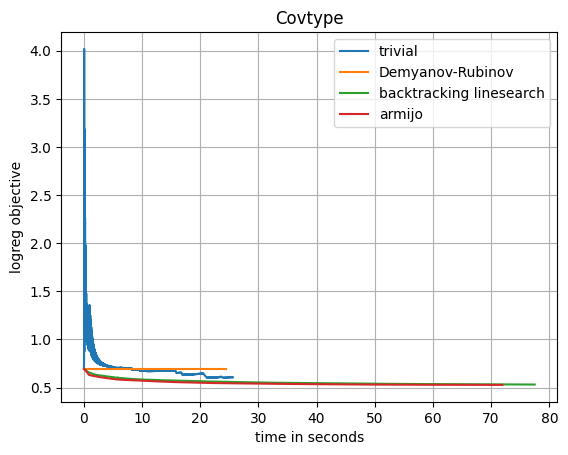

In [26]:
plt.title('Covtype')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armijo, losses_armijo, label='armijo')

plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.35)
# plt.xlim(0, 30)
plt.show();

### l2

In [35]:
n_iter = 1000

trivial_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_trivial, times_trivial = make_experiment_copt(trivial_exp_covtype)

dr_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_dr, times_dr = make_experiment_copt(dr_exp_covtype)

ls_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': n_iter,
    'Mt': init_M_copt(X_covtype, y_covtype, LMO_L2, 100, f.f_grad)
}
losses_ls, times_ls = make_experiment_copt(ls_exp_covtype)

armijo_exp_covtype = {
    'X': X_covtype,
    'y': y_covtype,
    'f': f,
    'x0': np.zeros(X_covtype.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': armijo,
    'alpha_init': 1.0 / 16,
    'objective': loss_logreg,
    'n_iter': n_iter,
}
losses_armijo, times_armijo = make_experiment_copt(armijo_exp_covtype)

100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


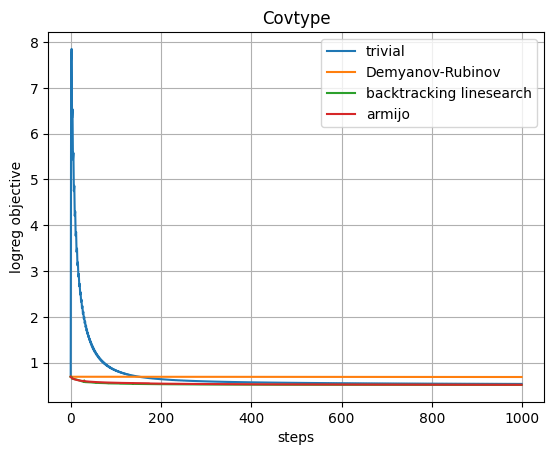

In [36]:
plt.title('Covtype')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label=f'armijo')

plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.4)
plt.show();

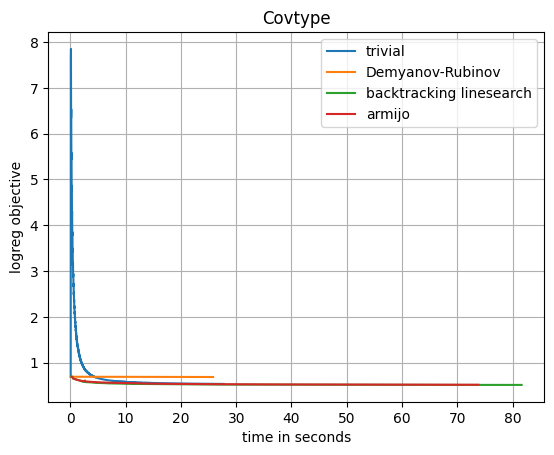

In [37]:
plt.title('Covtype')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armijo, losses_armijo, label='armijo')

plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
# plt.ylim(0.25, 0.35)
# plt.xlim(0, 30)
plt.show();